In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tensorflow.examples.tutorials.mnist import input_data
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def tic():
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    return time.time() - startTime_for_tictoc

In [3]:
def load_data():
    mnist = input_data.read_data_sets('MNIST_data/')
    images = np.append(np.append(mnist.train.images, mnist.validation.images, axis=0), mnist.test.images, axis=0)
    return images

In [4]:
def generator_output(noise_input, n_1, n_out, reuse=False):
    with tf.variable_scope('generator', reuse=reuse):
        A1 = tf.contrib.layers.fully_connected(noise_input, n_1, activation_fn=tf.nn.relu, scope='A1')
        A_out = tf.contrib.layers.fully_connected(A1, n_out, activation_fn=tf.nn.tanh, scope='A_out')
        return A_out

In [5]:
def discriminator_output(images, n_1, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        A1 = tf.contrib.layers.fully_connected(images, n_1, activation_fn=tf.nn.relu, scope='A1')
        Z_out = tf.contrib.layers.fully_connected(A1, 1, activation_fn=None, scope='Z_out')
        return Z_out

In [6]:
def MNIST_GAN_NN(hyperparams):
    tf.reset_default_graph()
    mnist_images = load_data() * 2 - 1
    noise_size = hyperparams['noise_size']
    batch_size = hyperparams['batch_size']
    epoch = hyperparams['epoch']
    generator_n_1 = hyperparams['generator_n_1']
    discriminator_n_1 = hyperparams['discriminator_n_1']
    learning_rate = hyperparams['learning_rate']
    sample_size = hyperparams['sample_size']
    data_size = mnist_images.shape[0]
    image_size = mnist_images.shape[1]
    total_batches = np.ceil(data_size / batch_size).astype(np.int32)
    real_images = tf.placeholder(tf.float32, (None, image_size), name='real_images')
    noise_input = tf.placeholder(tf.float32, (None, noise_size), name='noise_input')
    fake_images = generator_output(noise_input, generator_n_1, image_size)
    real_logits = discriminator_output(real_images, discriminator_n_1)
    fake_logits = discriminator_output(fake_images, discriminator_n_1, reuse=True)
    dis_real_cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_logits, labels=tf.ones_like(real_logits)))
    dis_fake_cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.zeros_like(fake_logits)))
    dis_cost = tf.divide(tf.add(dis_real_cost, dis_fake_cost), 2)
    gen_cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.ones_like(fake_logits)))
    trainable_vars = tf.trainable_variables()
    gen_vars = [var for var in trainable_vars if var.name.startswith('generator')]
    dis_vars = [var for var in trainable_vars if var.name.startswith('discriminator')]
    gen_optimize = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(gen_cost, var_list=gen_vars)
    dis_optimize = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(dis_cost, var_list=dis_vars)
    costs_history = []
    generate_sample_history = np.empty((0, sample_size, image_size))
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(epoch):
            tic()
            noises = np.empty((0, noise_size))
            for j in range(total_batches):
                index_front = j * batch_size
                index_end = (j + 1) * batch_size if (j + 1) * batch_size < data_size else data_size
                images_batch = mnist_images[index_front:index_end].reshape(-1, image_size)
                noise_batch = np.random.uniform(low=-1, high=1, size=(index_end - index_front, noise_size))
                sess.run(dis_optimize, feed_dict={real_images:images_batch, noise_input:noise_batch})
                sess.run(gen_optimize, feed_dict={noise_input:noise_batch})
                noises = np.append(noises, noise_batch, axis=0)
            dis_epoch_cost_real, dis_epoch_cost_fake, dis_epoch_cost, gen_epoch_cost = sess.run([dis_real_cost, dis_fake_cost, dis_cost, gen_cost], feed_dict={real_images:mnist_images, noise_input:noises})
            costs_history.append((dis_epoch_cost_real, dis_epoch_cost_fake, dis_epoch_cost, gen_epoch_cost))
            generate_sample_history = np.append(generate_sample_history, sess.run(fake_images, feed_dict={noise_input:noises[0:sample_size].reshape(-1, noise_size)}).reshape(1, -1, image_size), axis=0)
            print('Epoch {}/{} Time Elapsed: {:.2f}s'.format(i + 1, epoch, toc()))
            print('Discriminator Cost: {:.4f} (Real: {:.4f} + Fake: {:.4f}) Generator Cost: {:.4f}'.format(dis_epoch_cost, dis_epoch_cost_real, dis_epoch_cost_fake, gen_epoch_cost))
        return costs_history, generate_sample_history

In [7]:
hyperparams={
    'noise_size': 100,
    'batch_size': 64,
    'epoch': 500,
    'generator_n_1': 128,
    'discriminator_n_1': 128,
    'learning_rate': 0.001,
    'sample_size': 5
}
costs_history, generate_sample_history = MNIST_GAN_NN(hyperparams)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Epoch 1/500 Time Elapsed: 15.41s
Discriminator Cost: 0.7072 (Real: 0.5694 + Fake: 0.8450) Generator Cost: 3.4053
Epoch 2/500 Time Elapsed: 16.09s
Discriminator Cost: 1.9541 (Real: 3.5672 + Fake: 0.3411) Generator Cost: 4.0906
Epoch 3/500 Time Elapsed: 15.62s
Discriminator Cost: 0.7696 (Real: 0.3829 + Fake: 1.1563) Generator Cost: 3.7171
Epoch 4/500 Time Elapsed: 14.88s
Discriminator Cost: 1.0703 (Real: 0.9528 + Fake: 1.1878) Generator Cost: 0.7071
Epoch 5/500 Time Elapsed: 14.85s
Discriminator Cost: 0.7487 (Real: 1.1188 + Fake: 0.3786) Generator Cost: 1.5869
Epoch 6/500 Time Elapsed: 14.60s
Discriminator Cost: 0.4913 (Real: 0.6299 + Fake: 0.3526) Generator Cost: 2.5801
Epoch 7/500 Time Elapsed: 14.66s
Discriminator Cost: 0.6132 (Real: 0.5278 + Fake: 0.6987) Generator Cost: 0.8305
Epoch 8/500 Tim

Epoch 72/500 Time Elapsed: 14.63s
Discriminator Cost: 0.6096 (Real: 0.5016 + Fake: 0.7177) Generator Cost: 0.9667
Epoch 73/500 Time Elapsed: 14.73s
Discriminator Cost: 0.6139 (Real: 0.5488 + Fake: 0.6790) Generator Cost: 1.1222
Epoch 74/500 Time Elapsed: 14.75s
Discriminator Cost: 0.9929 (Real: 0.9889 + Fake: 0.9969) Generator Cost: 0.7610
Epoch 75/500 Time Elapsed: 14.75s
Discriminator Cost: 0.7277 (Real: 0.7414 + Fake: 0.7140) Generator Cost: 1.1398
Epoch 76/500 Time Elapsed: 14.78s
Discriminator Cost: 0.8316 (Real: 0.7817 + Fake: 0.8814) Generator Cost: 0.8118
Epoch 77/500 Time Elapsed: 14.77s
Discriminator Cost: 0.5512 (Real: 0.4227 + Fake: 0.6798) Generator Cost: 1.0987
Epoch 78/500 Time Elapsed: 14.63s
Discriminator Cost: 0.6870 (Real: 0.6630 + Fake: 0.7110) Generator Cost: 0.9839
Epoch 79/500 Time Elapsed: 14.81s
Discriminator Cost: 0.6205 (Real: 0.5764 + Fake: 0.6646) Generator Cost: 1.0617
Epoch 80/500 Time Elapsed: 14.70s
Discriminator Cost: 0.5508 (Real: 0.6300 + Fake: 0.471

Epoch 144/500 Time Elapsed: 14.48s
Discriminator Cost: 0.6790 (Real: 0.6327 + Fake: 0.7253) Generator Cost: 0.9374
Epoch 145/500 Time Elapsed: 14.50s
Discriminator Cost: 0.6861 (Real: 0.5581 + Fake: 0.8141) Generator Cost: 0.8581
Epoch 146/500 Time Elapsed: 14.55s
Discriminator Cost: 0.6105 (Real: 0.5508 + Fake: 0.6702) Generator Cost: 1.0400
Epoch 147/500 Time Elapsed: 14.55s
Discriminator Cost: 0.6584 (Real: 0.7048 + Fake: 0.6119) Generator Cost: 1.1305
Epoch 148/500 Time Elapsed: 14.52s
Discriminator Cost: 0.6589 (Real: 0.6009 + Fake: 0.7168) Generator Cost: 1.0126
Epoch 149/500 Time Elapsed: 14.83s
Discriminator Cost: 0.7030 (Real: 0.7338 + Fake: 0.6722) Generator Cost: 1.0441
Epoch 150/500 Time Elapsed: 14.84s
Discriminator Cost: 0.6409 (Real: 0.6119 + Fake: 0.6699) Generator Cost: 1.0243
Epoch 151/500 Time Elapsed: 14.88s
Discriminator Cost: 0.5997 (Real: 0.5038 + Fake: 0.6955) Generator Cost: 1.0741
Epoch 152/500 Time Elapsed: 14.93s
Discriminator Cost: 0.6816 (Real: 0.6464 + Fa

Epoch 216/500 Time Elapsed: 14.60s
Discriminator Cost: 0.6664 (Real: 0.5184 + Fake: 0.8144) Generator Cost: 0.8646
Epoch 217/500 Time Elapsed: 14.69s
Discriminator Cost: 0.6923 (Real: 0.5675 + Fake: 0.8171) Generator Cost: 0.8795
Epoch 218/500 Time Elapsed: 14.52s
Discriminator Cost: 0.6942 (Real: 0.6519 + Fake: 0.7365) Generator Cost: 0.9472
Epoch 219/500 Time Elapsed: 14.63s
Discriminator Cost: 0.7029 (Real: 0.5779 + Fake: 0.8279) Generator Cost: 0.9209
Epoch 220/500 Time Elapsed: 14.68s
Discriminator Cost: 0.6638 (Real: 0.4453 + Fake: 0.8823) Generator Cost: 0.8180
Epoch 221/500 Time Elapsed: 14.52s
Discriminator Cost: 0.6161 (Real: 0.4855 + Fake: 0.7468) Generator Cost: 0.9935
Epoch 222/500 Time Elapsed: 14.54s
Discriminator Cost: 0.6862 (Real: 0.6259 + Fake: 0.7464) Generator Cost: 0.9698
Epoch 223/500 Time Elapsed: 14.53s
Discriminator Cost: 0.7910 (Real: 0.7105 + Fake: 0.8715) Generator Cost: 0.8827
Epoch 224/500 Time Elapsed: 14.74s
Discriminator Cost: 0.7917 (Real: 0.6962 + Fa

Epoch 288/500 Time Elapsed: 14.74s
Discriminator Cost: 0.7003 (Real: 0.6279 + Fake: 0.7726) Generator Cost: 0.9250
Epoch 289/500 Time Elapsed: 14.78s
Discriminator Cost: 0.7115 (Real: 0.6554 + Fake: 0.7676) Generator Cost: 0.8950
Epoch 290/500 Time Elapsed: 14.60s
Discriminator Cost: 0.6409 (Real: 0.5558 + Fake: 0.7259) Generator Cost: 0.9812
Epoch 291/500 Time Elapsed: 14.65s
Discriminator Cost: 0.7024 (Real: 0.6975 + Fake: 0.7073) Generator Cost: 0.9437
Epoch 292/500 Time Elapsed: 14.66s
Discriminator Cost: 0.5867 (Real: 0.4873 + Fake: 0.6860) Generator Cost: 1.0585
Epoch 293/500 Time Elapsed: 14.62s
Discriminator Cost: 0.7537 (Real: 0.6987 + Fake: 0.8087) Generator Cost: 0.9015
Epoch 294/500 Time Elapsed: 14.68s
Discriminator Cost: 0.7840 (Real: 0.8506 + Fake: 0.7175) Generator Cost: 0.9571
Epoch 295/500 Time Elapsed: 14.62s
Discriminator Cost: 0.7338 (Real: 0.6545 + Fake: 0.8131) Generator Cost: 0.8833
Epoch 296/500 Time Elapsed: 14.41s
Discriminator Cost: 0.7483 (Real: 0.5384 + Fa

Epoch 360/500 Time Elapsed: 14.42s
Discriminator Cost: 0.5847 (Real: 0.5756 + Fake: 0.5939) Generator Cost: 1.2551
Epoch 361/500 Time Elapsed: 14.51s
Discriminator Cost: 0.6488 (Real: 0.6611 + Fake: 0.6365) Generator Cost: 1.1082
Epoch 362/500 Time Elapsed: 14.61s
Discriminator Cost: 0.6186 (Real: 0.6474 + Fake: 0.5899) Generator Cost: 1.2289
Epoch 363/500 Time Elapsed: 14.26s
Discriminator Cost: 0.7005 (Real: 0.5734 + Fake: 0.8276) Generator Cost: 0.9260
Epoch 364/500 Time Elapsed: 14.41s
Discriminator Cost: 0.6775 (Real: 0.5391 + Fake: 0.8159) Generator Cost: 0.9476
Epoch 365/500 Time Elapsed: 14.48s
Discriminator Cost: 0.6550 (Real: 0.7183 + Fake: 0.5916) Generator Cost: 1.1769
Epoch 366/500 Time Elapsed: 14.89s
Discriminator Cost: 0.6737 (Real: 0.6139 + Fake: 0.7335) Generator Cost: 1.0707
Epoch 367/500 Time Elapsed: 14.80s
Discriminator Cost: 0.7210 (Real: 0.5181 + Fake: 0.9239) Generator Cost: 0.8696
Epoch 368/500 Time Elapsed: 14.60s
Discriminator Cost: 0.6037 (Real: 0.6130 + Fa

Epoch 432/500 Time Elapsed: 14.51s
Discriminator Cost: 0.5943 (Real: 0.6582 + Fake: 0.5305) Generator Cost: 1.3141
Epoch 433/500 Time Elapsed: 14.51s
Discriminator Cost: 0.6227 (Real: 0.6868 + Fake: 0.5587) Generator Cost: 1.2359
Epoch 434/500 Time Elapsed: 14.55s
Discriminator Cost: 0.6835 (Real: 0.6387 + Fake: 0.7283) Generator Cost: 1.0613
Epoch 435/500 Time Elapsed: 14.48s
Discriminator Cost: 0.7094 (Real: 0.6907 + Fake: 0.7280) Generator Cost: 0.9606
Epoch 436/500 Time Elapsed: 14.52s
Discriminator Cost: 0.6629 (Real: 0.5807 + Fake: 0.7451) Generator Cost: 0.9515
Epoch 437/500 Time Elapsed: 14.57s
Discriminator Cost: 0.5934 (Real: 0.5608 + Fake: 0.6260) Generator Cost: 1.1569
Epoch 438/500 Time Elapsed: 14.56s
Discriminator Cost: 0.6258 (Real: 0.5709 + Fake: 0.6806) Generator Cost: 1.0863
Epoch 439/500 Time Elapsed: 14.66s
Discriminator Cost: 0.6351 (Real: 0.5525 + Fake: 0.7177) Generator Cost: 1.0124
Epoch 440/500 Time Elapsed: 14.78s
Discriminator Cost: 0.5552 (Real: 0.5019 + Fa

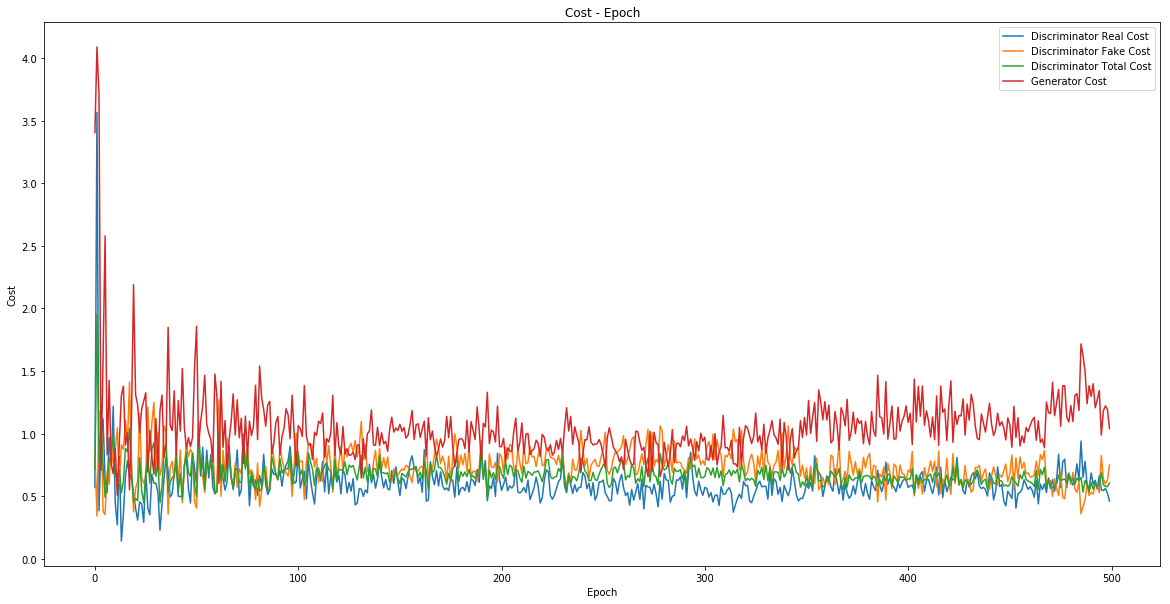

In [8]:
costs = np.array(costs_history).T
plt.figure(figsize=(20, 10))
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.title('Cost - Epoch')
plt.plot(costs[0], label='Discriminator Real Cost')
plt.plot(costs[1], label='Discriminator Fake Cost')
plt.plot(costs[2], label='Discriminator Total Cost')
plt.plot(costs[3], label='Generator Cost')
plt.legend(loc='best')
plt.show()

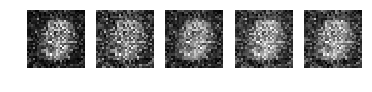

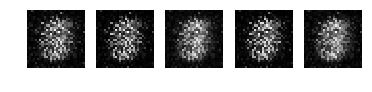

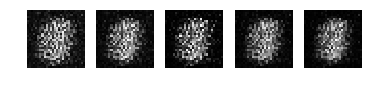

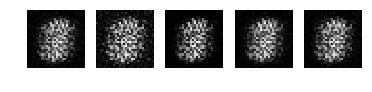

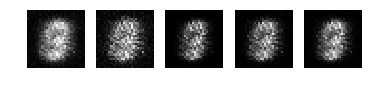

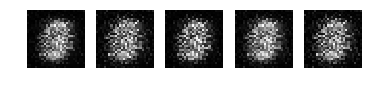

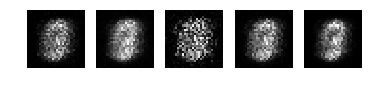

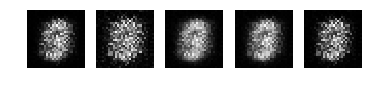

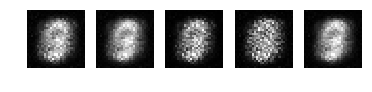

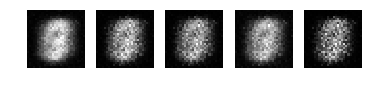

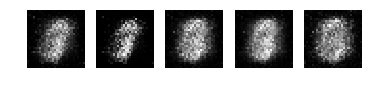

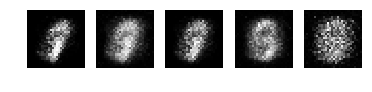

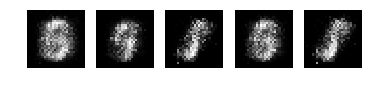

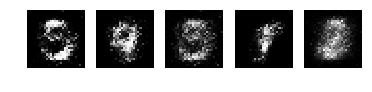

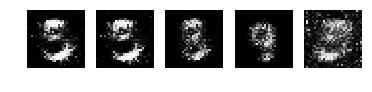

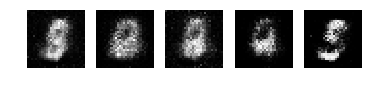

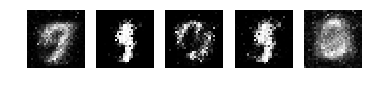

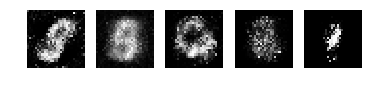

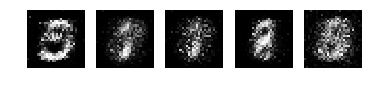

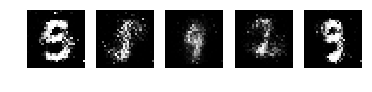

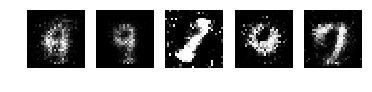

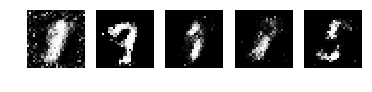

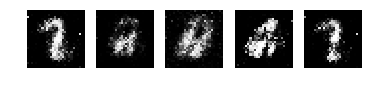

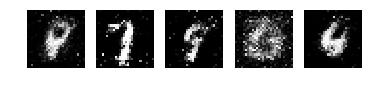

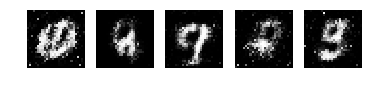

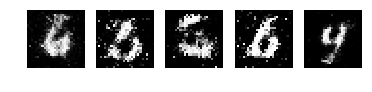

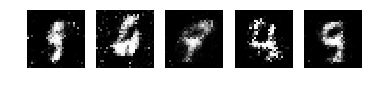

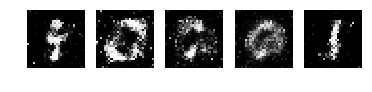

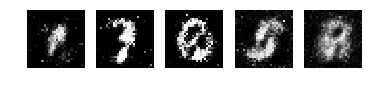

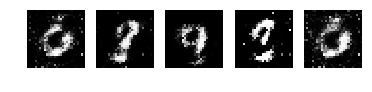

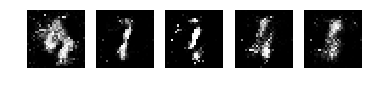

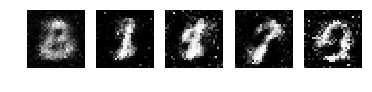

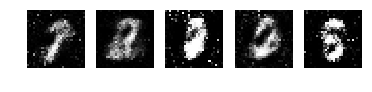

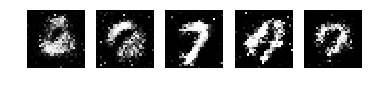

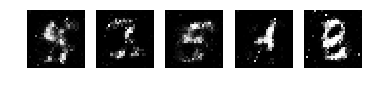

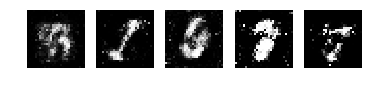

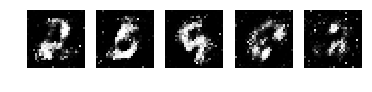

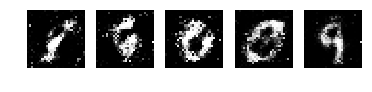

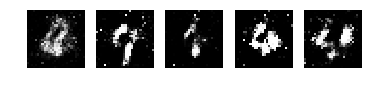

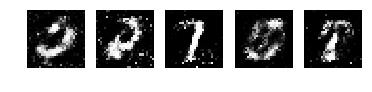

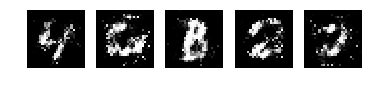

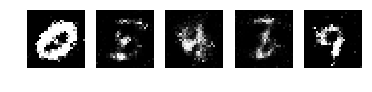

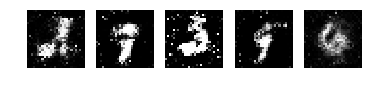

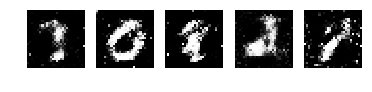

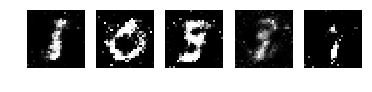

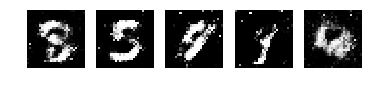

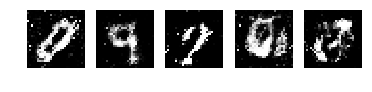

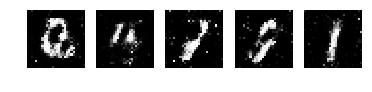

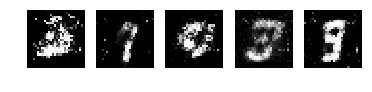

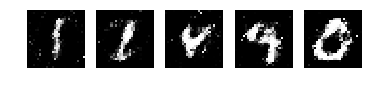

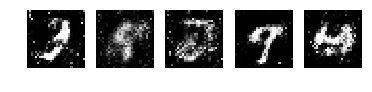

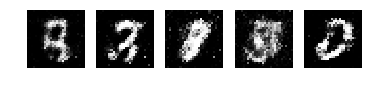

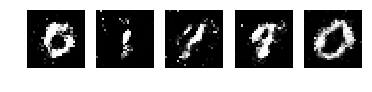

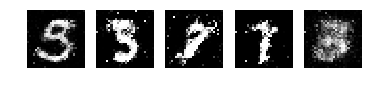

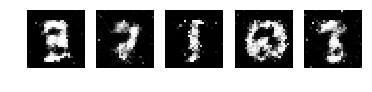

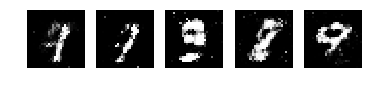

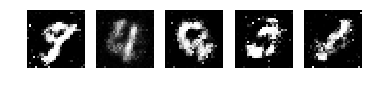

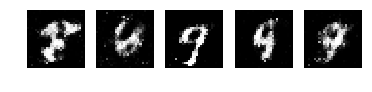

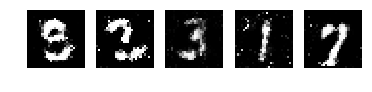

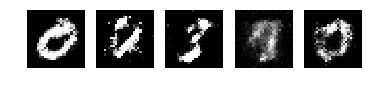

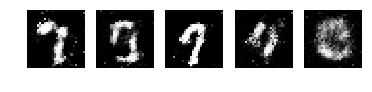

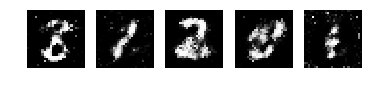

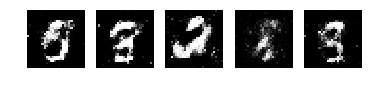

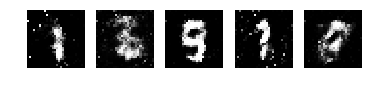

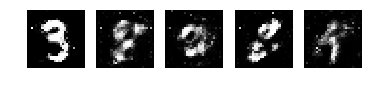

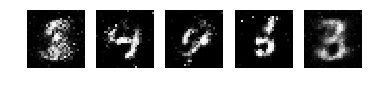

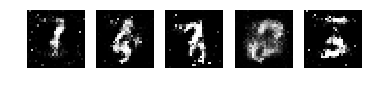

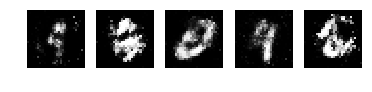

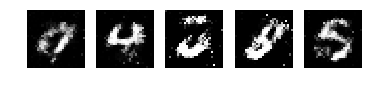

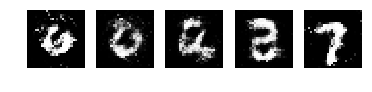

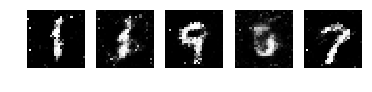

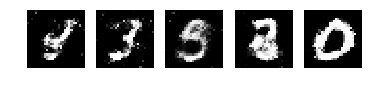

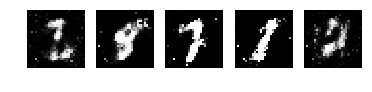

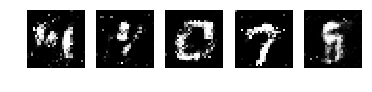

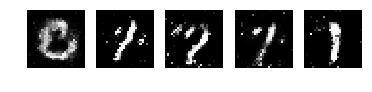

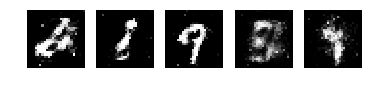

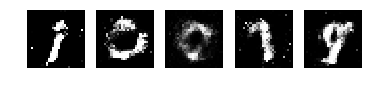

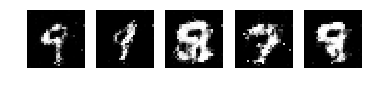

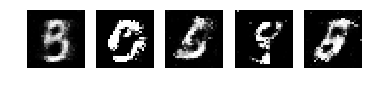

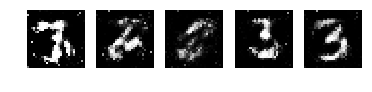

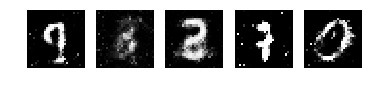

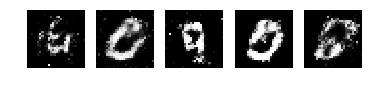

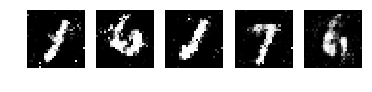

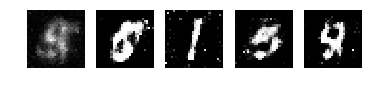

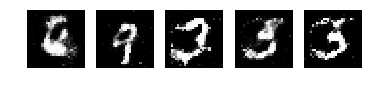

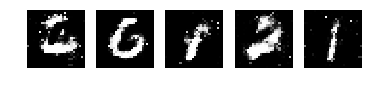

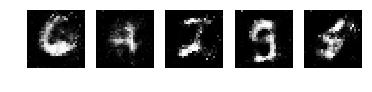

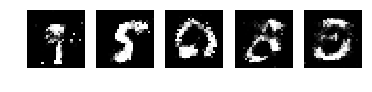

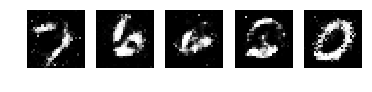

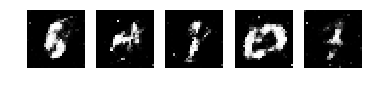

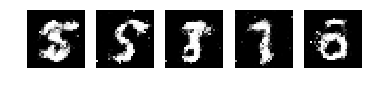

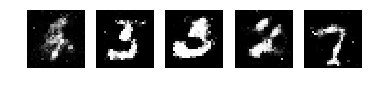

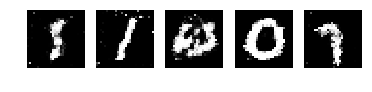

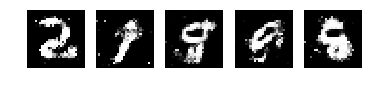

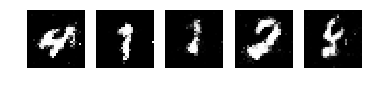

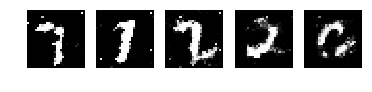

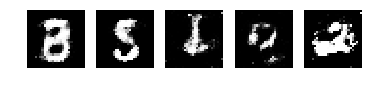

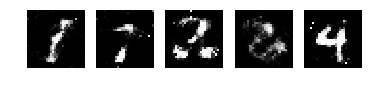

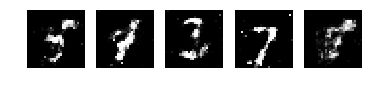

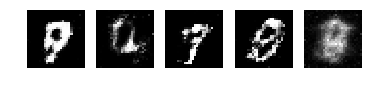

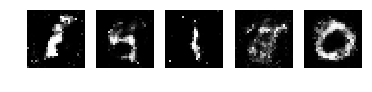

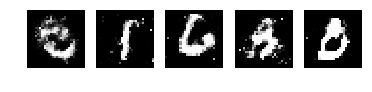

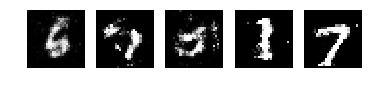

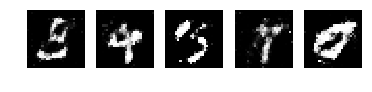

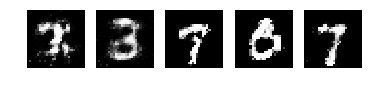

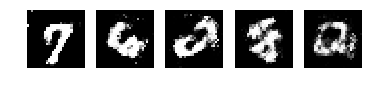

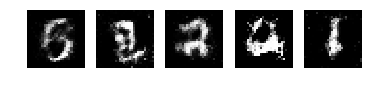

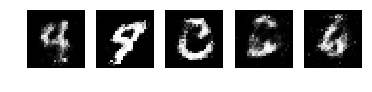

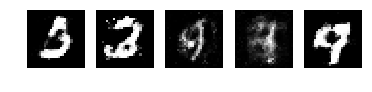

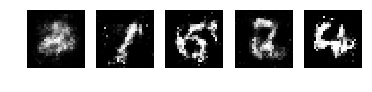

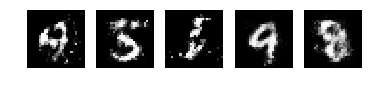

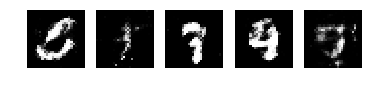

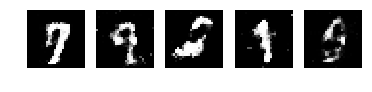

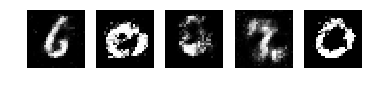

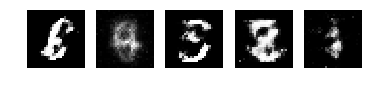

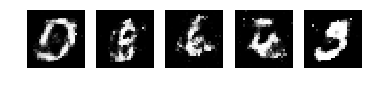

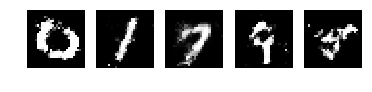

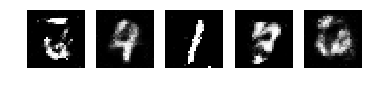

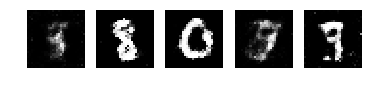

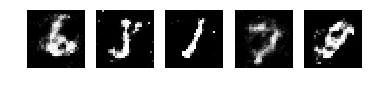

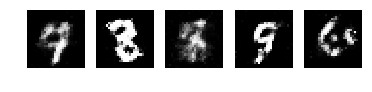

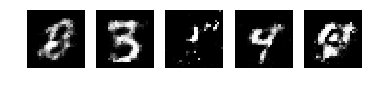

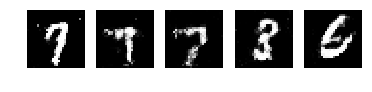

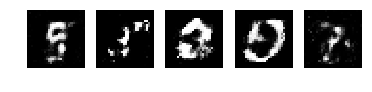

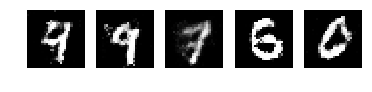

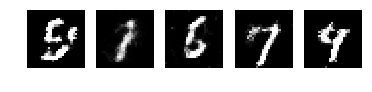

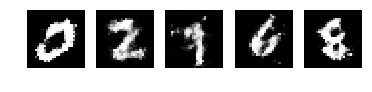

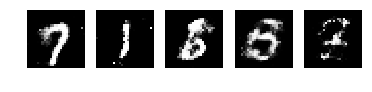

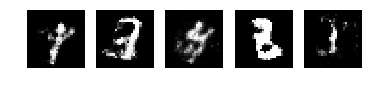

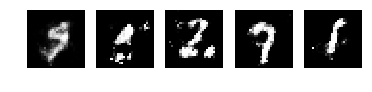

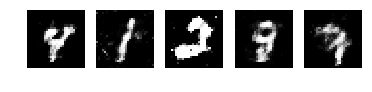

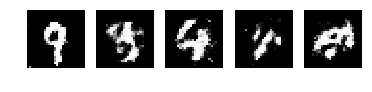

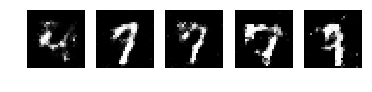

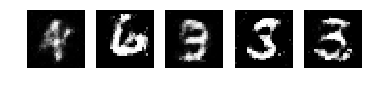

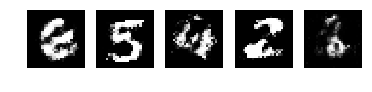

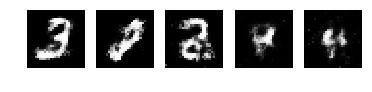

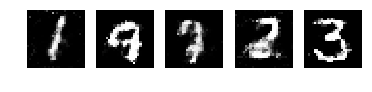

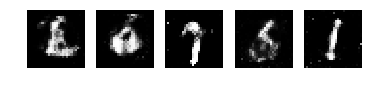

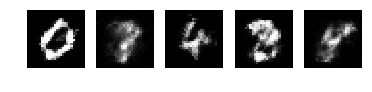

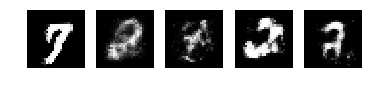

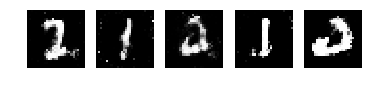

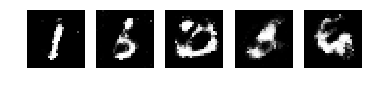

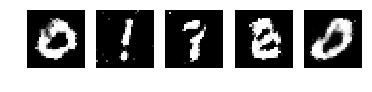

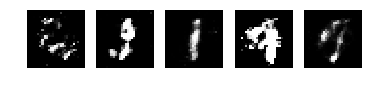

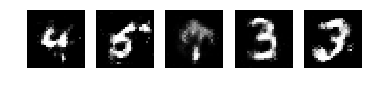

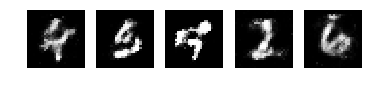

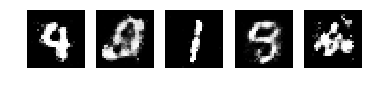

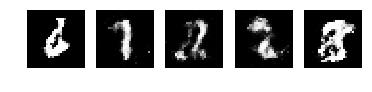

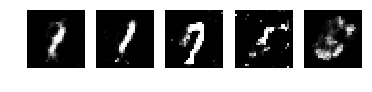

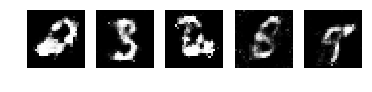

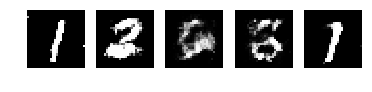

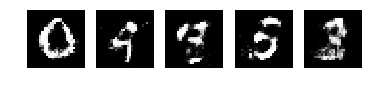

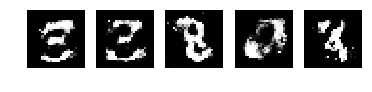

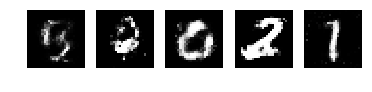

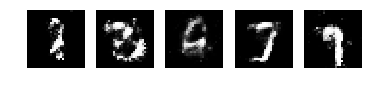

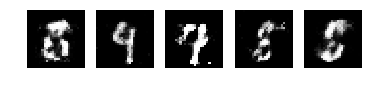

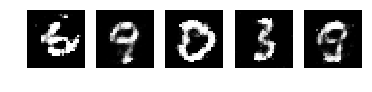

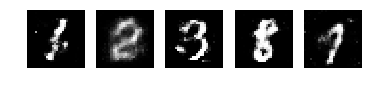

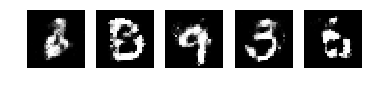

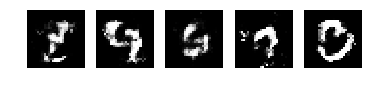

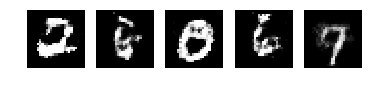

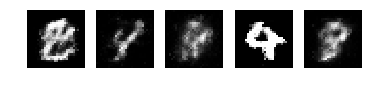

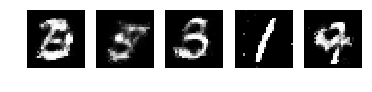

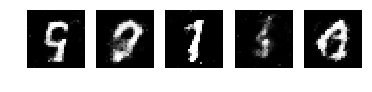

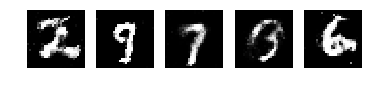

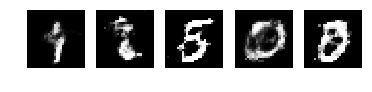

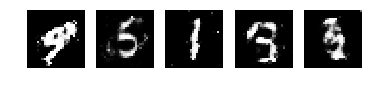

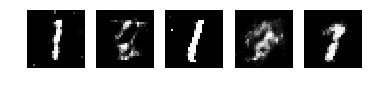

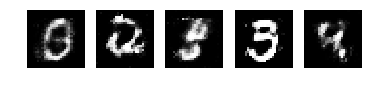

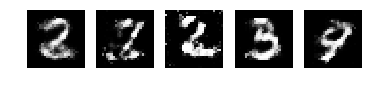

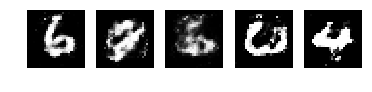

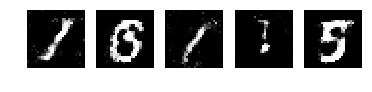

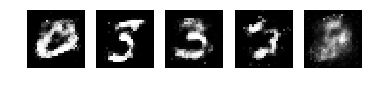

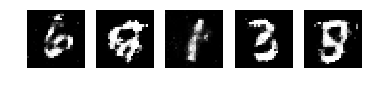

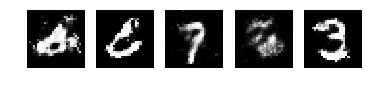

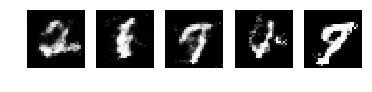

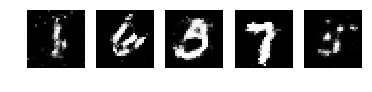

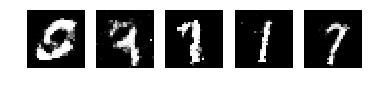

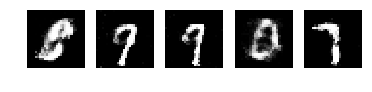

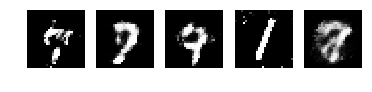

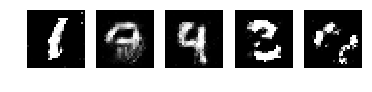

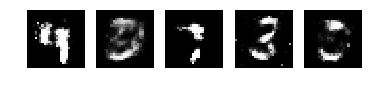

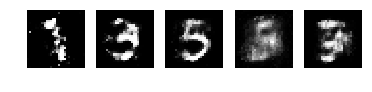

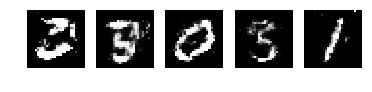

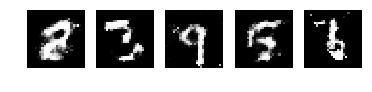

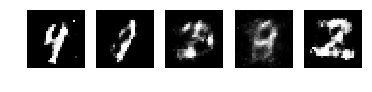

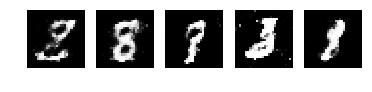

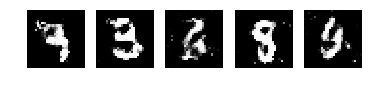

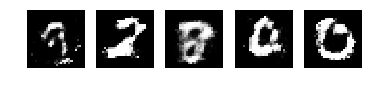

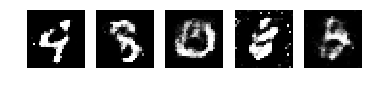

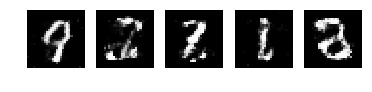

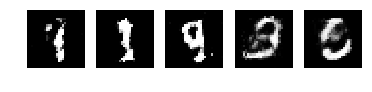

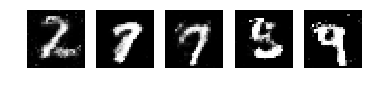

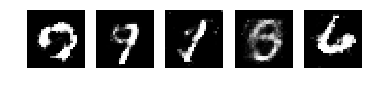

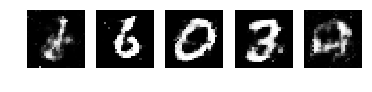

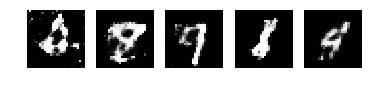

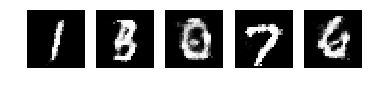

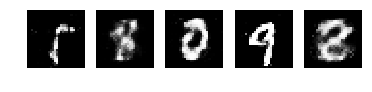

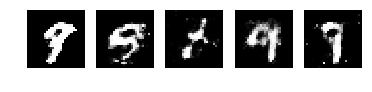

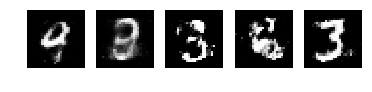

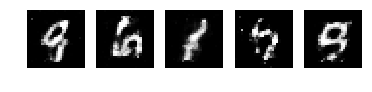

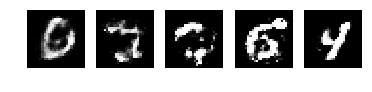

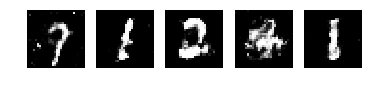

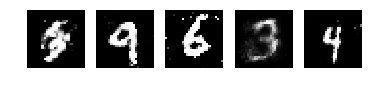

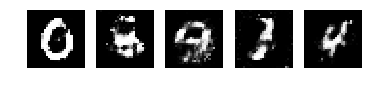

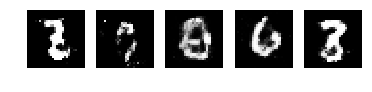

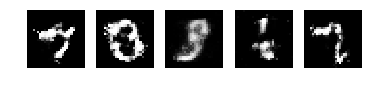

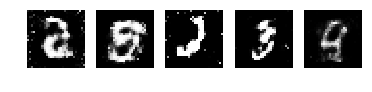

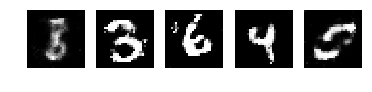

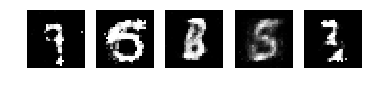

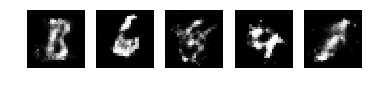

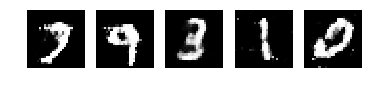

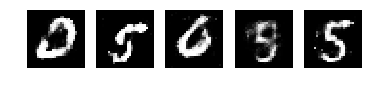

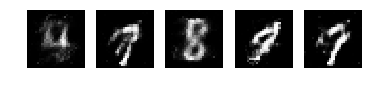

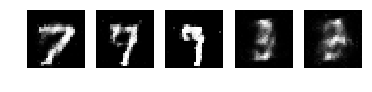

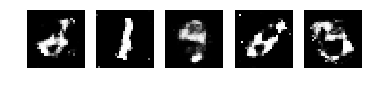

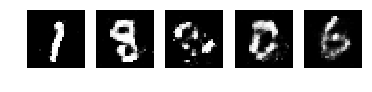

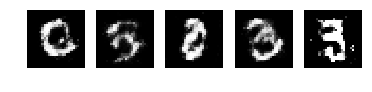

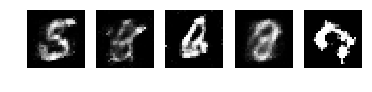

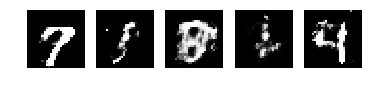

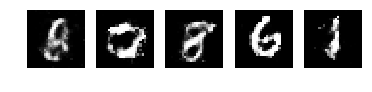

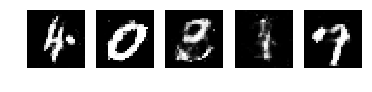

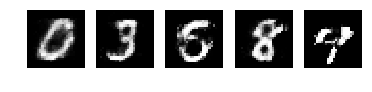

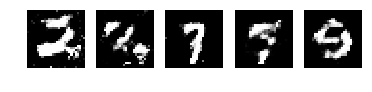

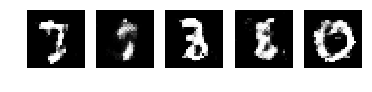

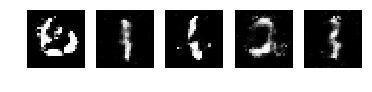

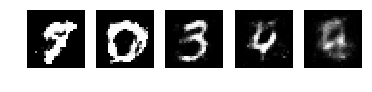

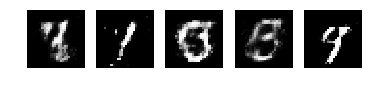

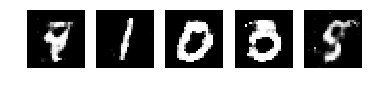

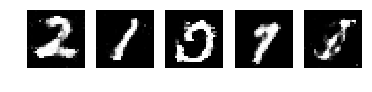

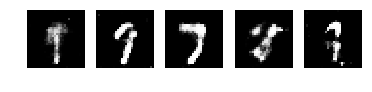

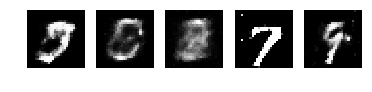

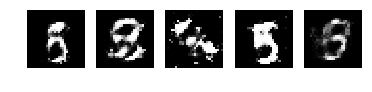

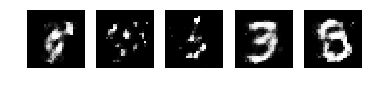

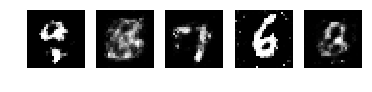

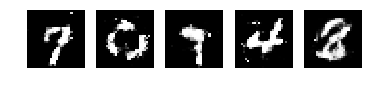

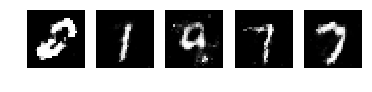

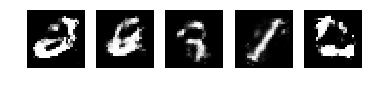

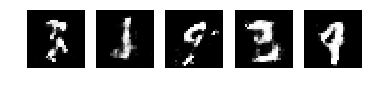

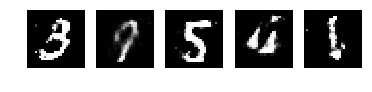

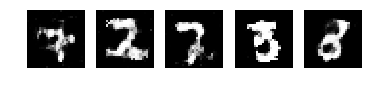

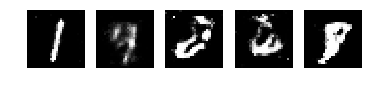

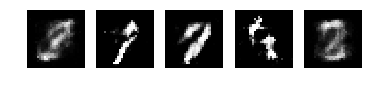

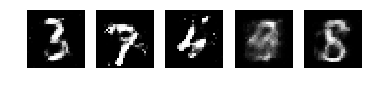

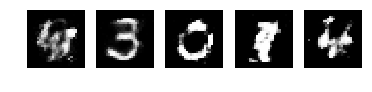

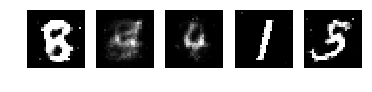

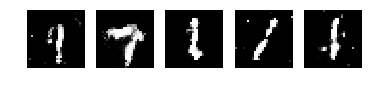

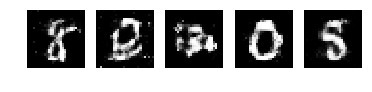

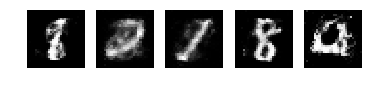

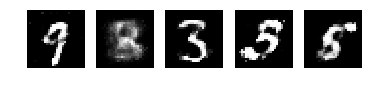

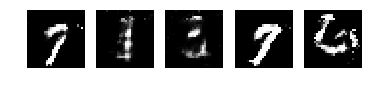

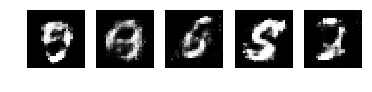

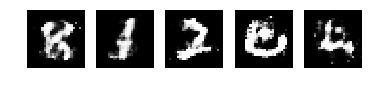

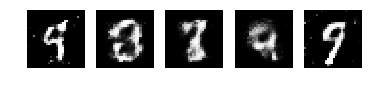

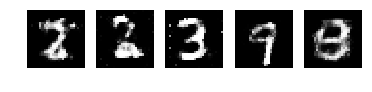

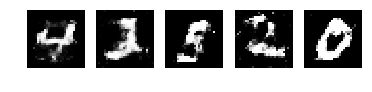

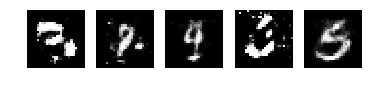

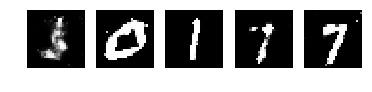

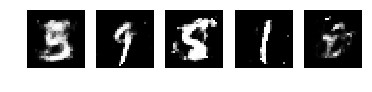

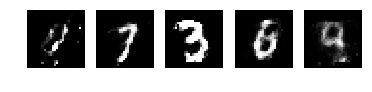

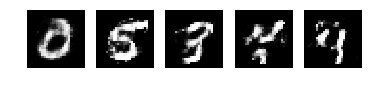

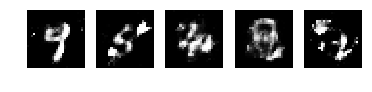

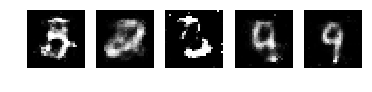

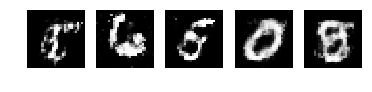

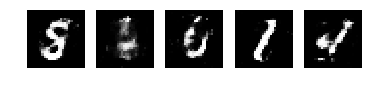

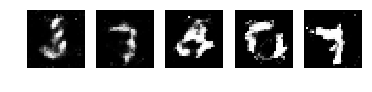

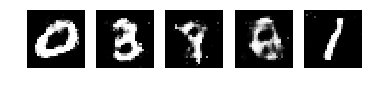

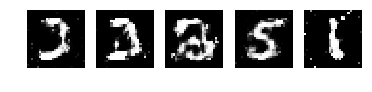

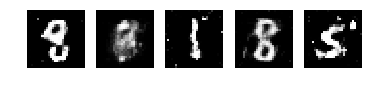

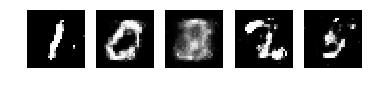

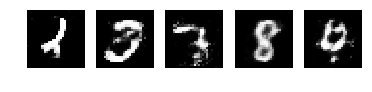

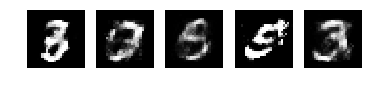

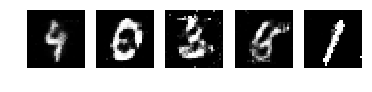

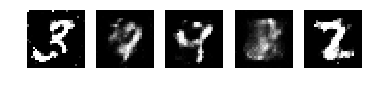

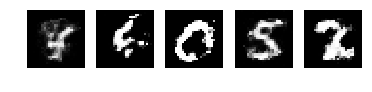

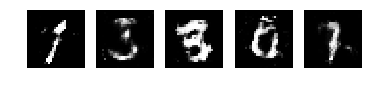

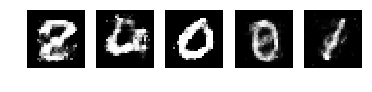

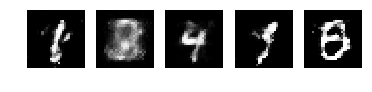

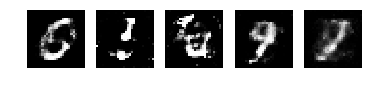

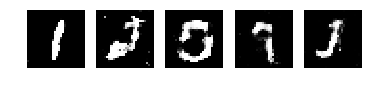

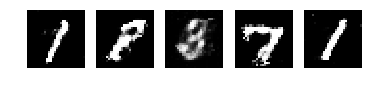

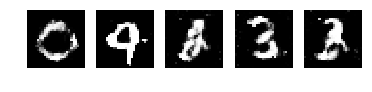

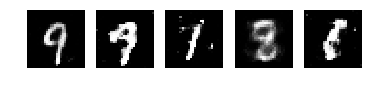

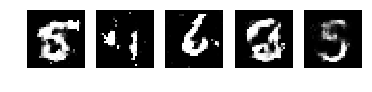

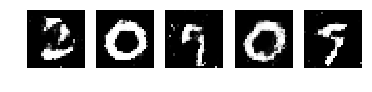

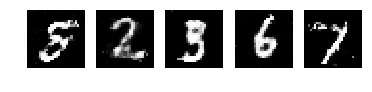

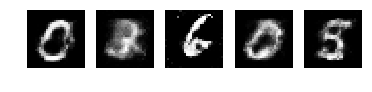

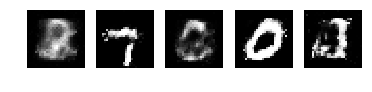

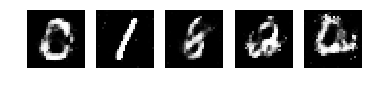

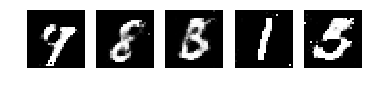

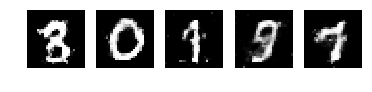

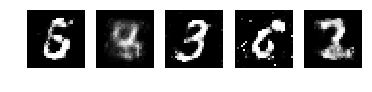

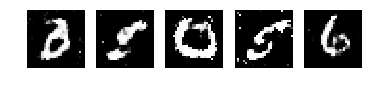

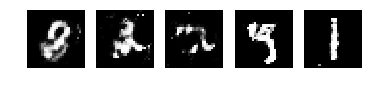

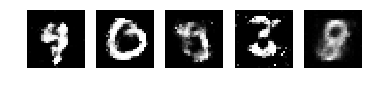

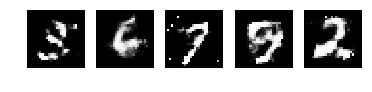

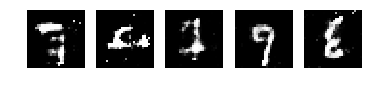

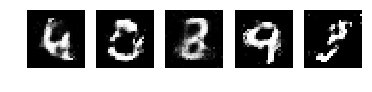

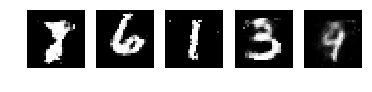

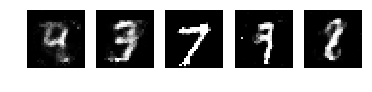

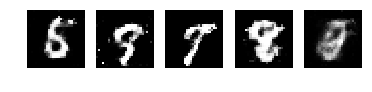

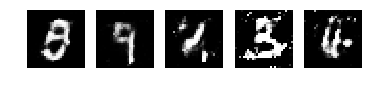

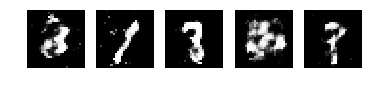

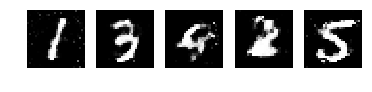

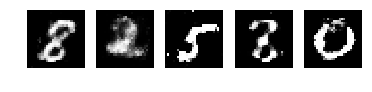

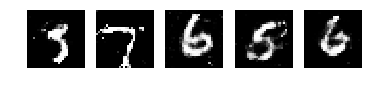

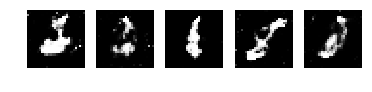

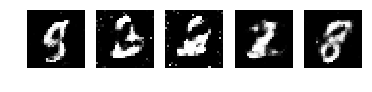

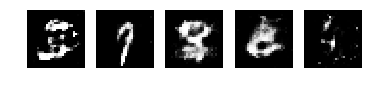

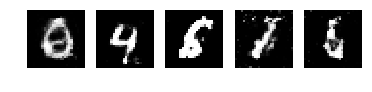

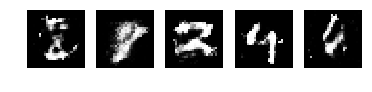

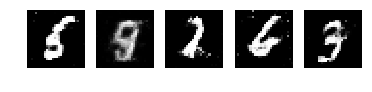

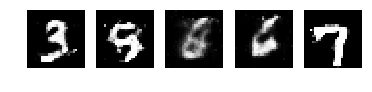

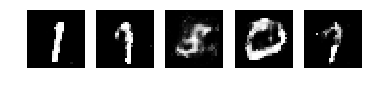

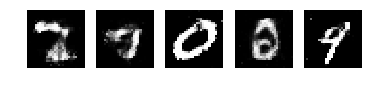

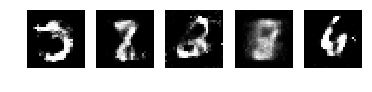

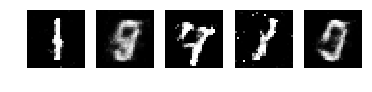

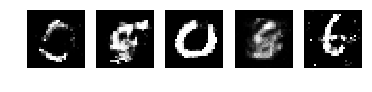

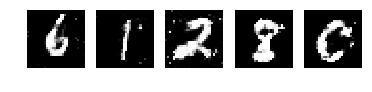

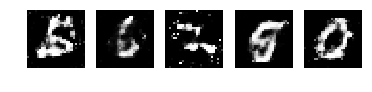

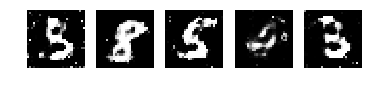

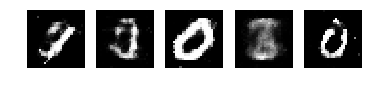

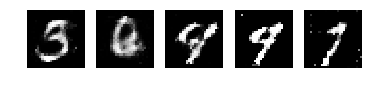

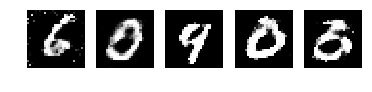

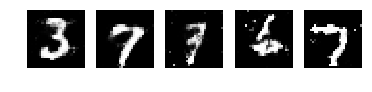

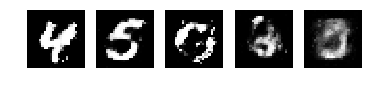

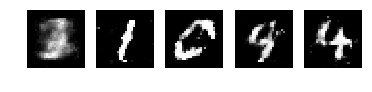

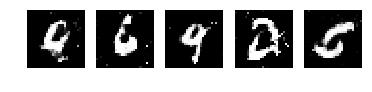

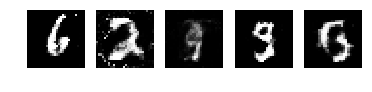

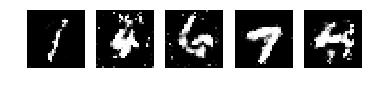

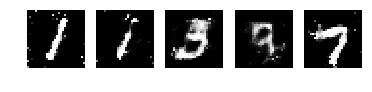

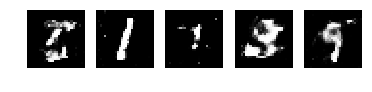

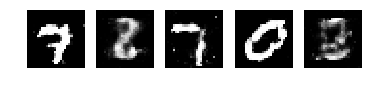

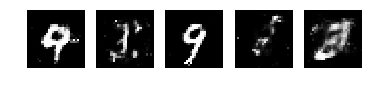

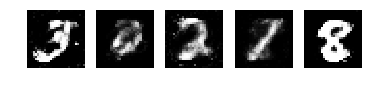

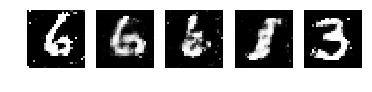

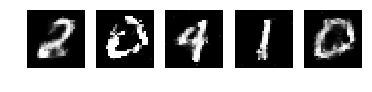

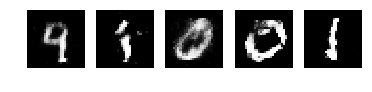

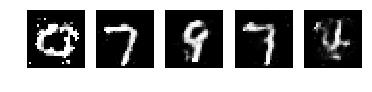

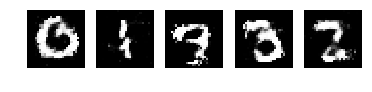

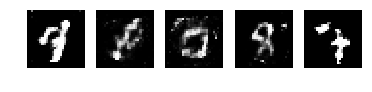

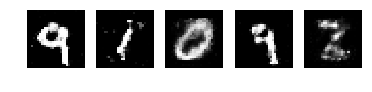

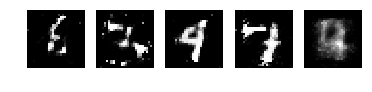

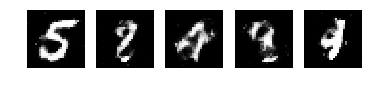

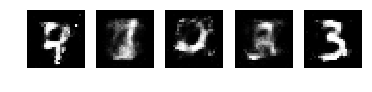

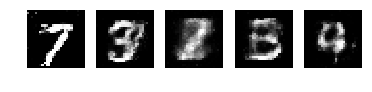

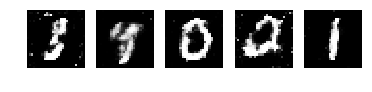

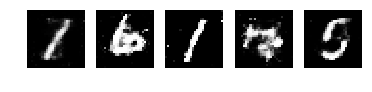

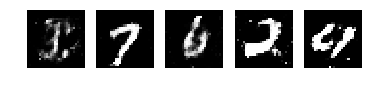

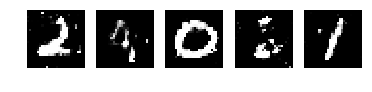

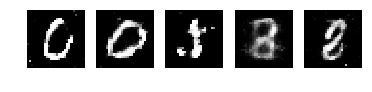

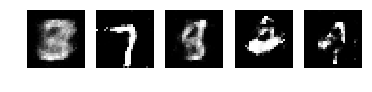

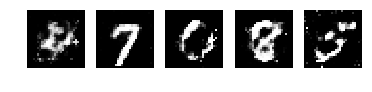

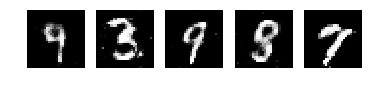

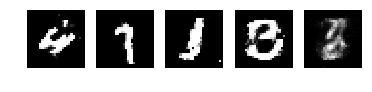

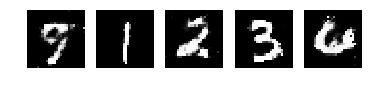

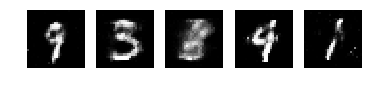

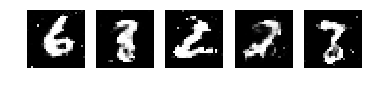

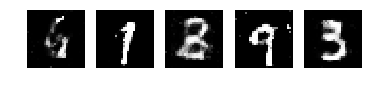

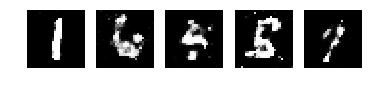

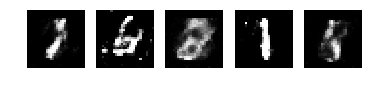

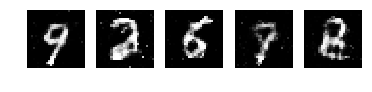

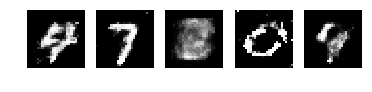

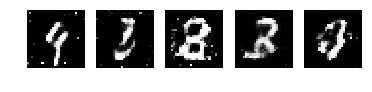

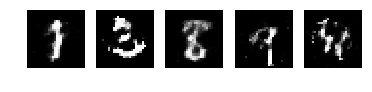

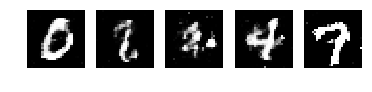

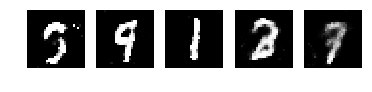

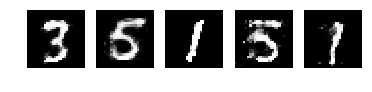

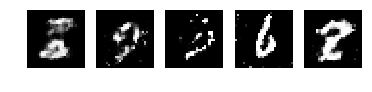

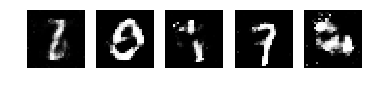

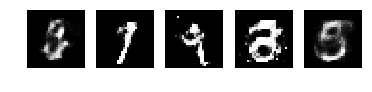

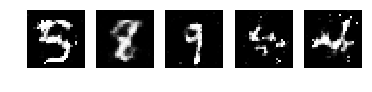

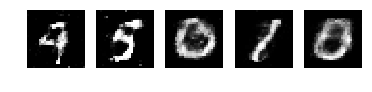

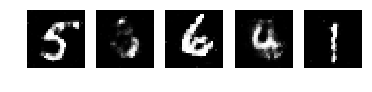

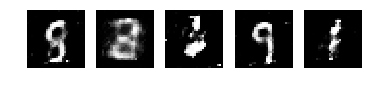

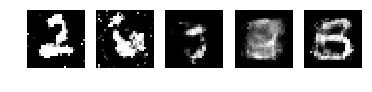

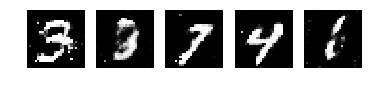

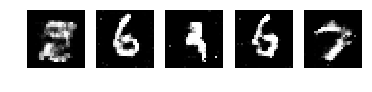

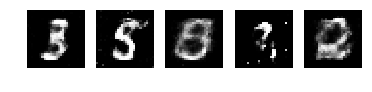

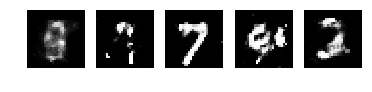

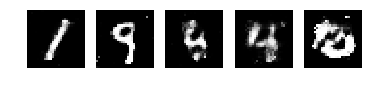

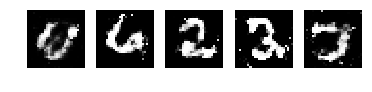

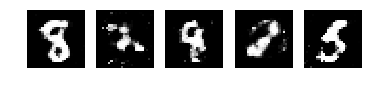

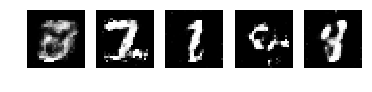

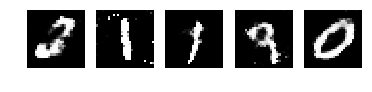

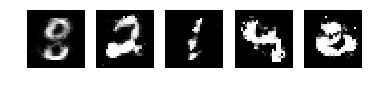

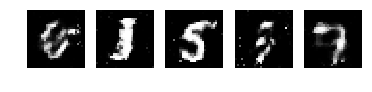

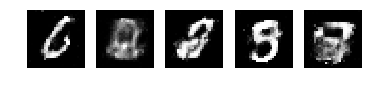

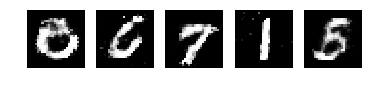

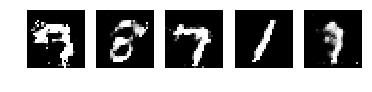

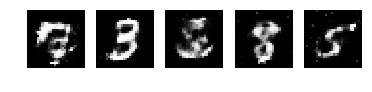

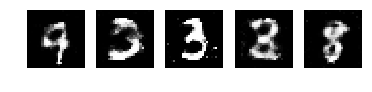

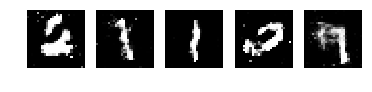

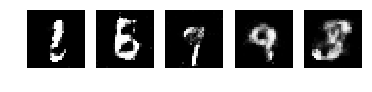

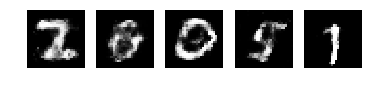

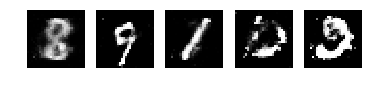

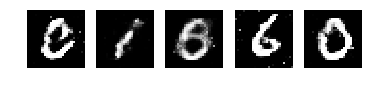

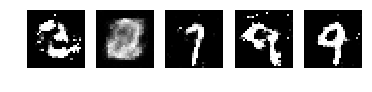

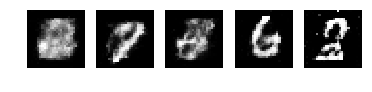

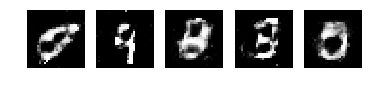

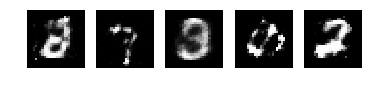

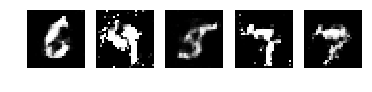

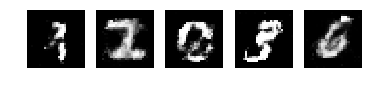

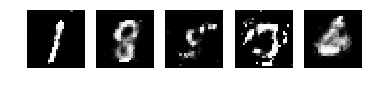

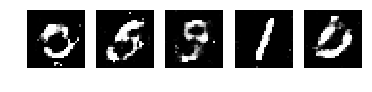

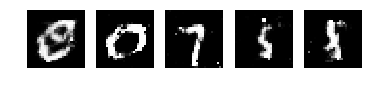

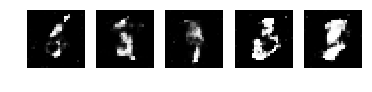

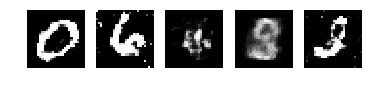

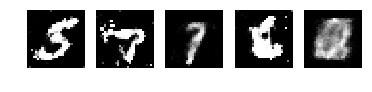

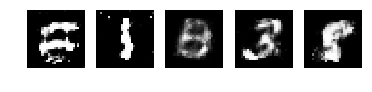

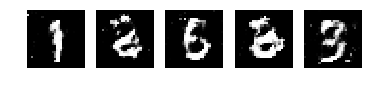

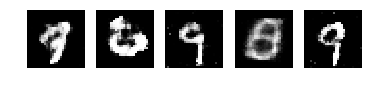

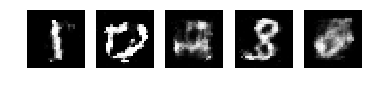

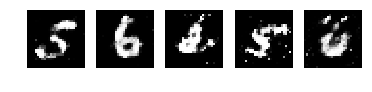

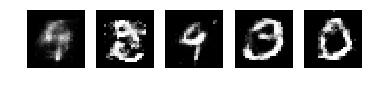

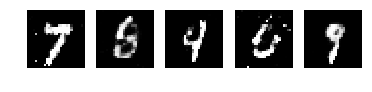

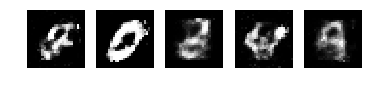

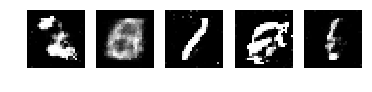

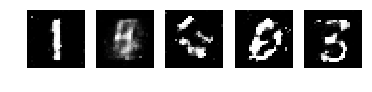

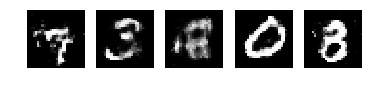

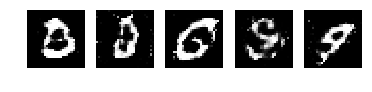

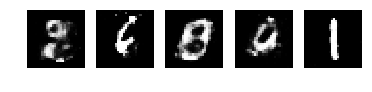

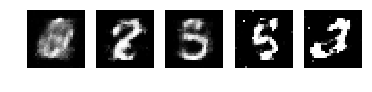

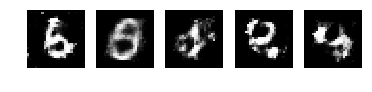

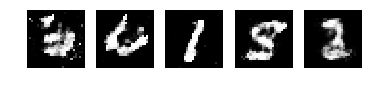

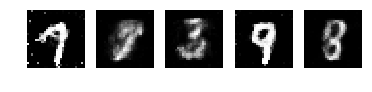

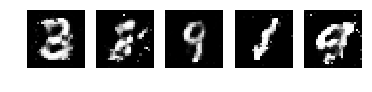

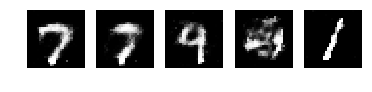

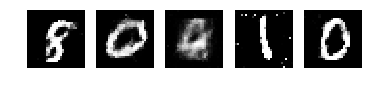

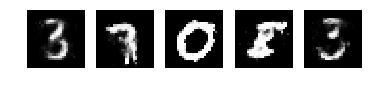

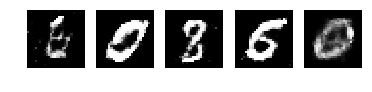

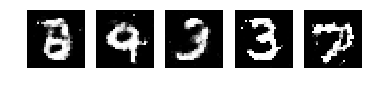

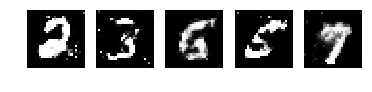

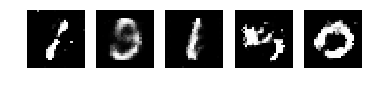

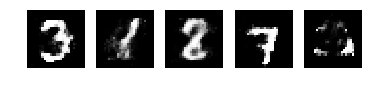

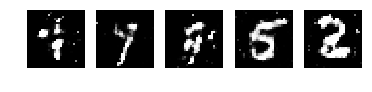

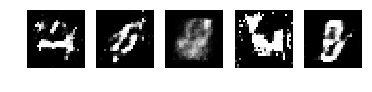

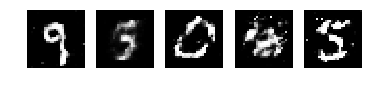

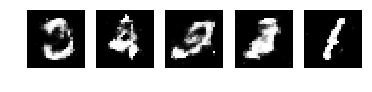

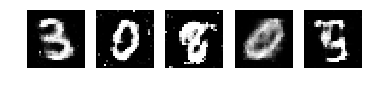

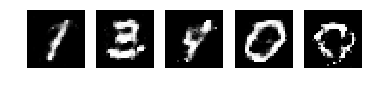

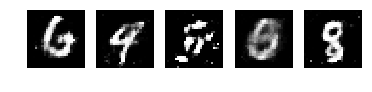

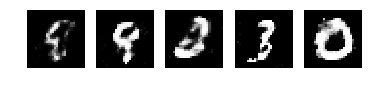

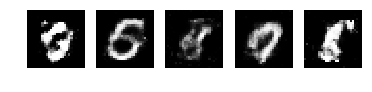

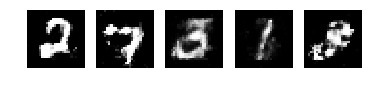

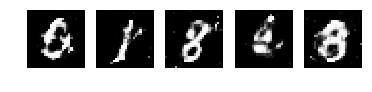

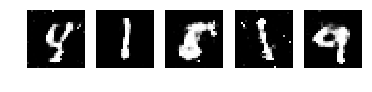

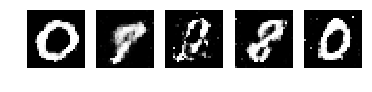

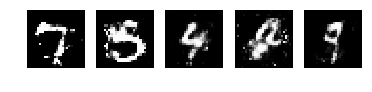

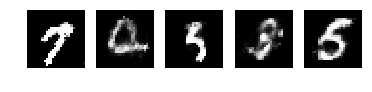

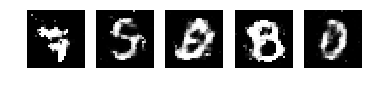

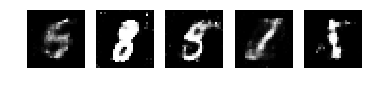

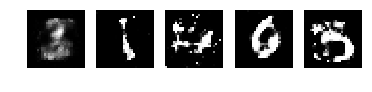

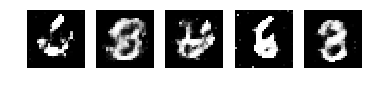

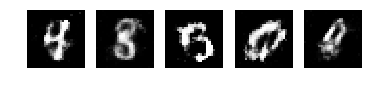

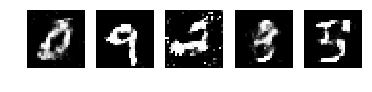

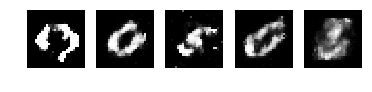

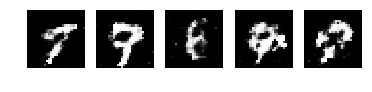

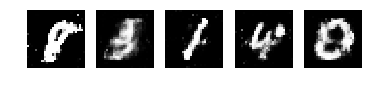

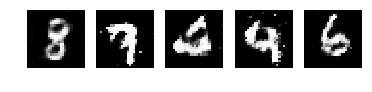

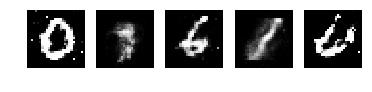

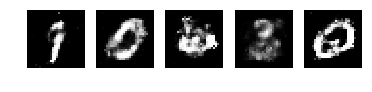

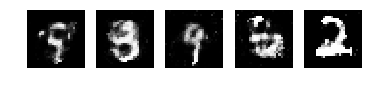

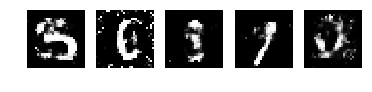

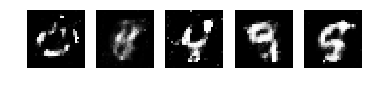

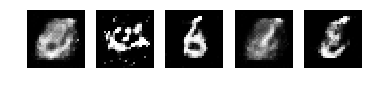

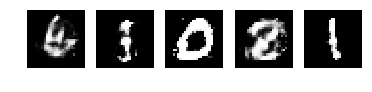

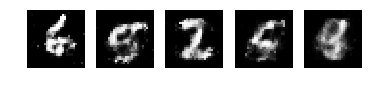

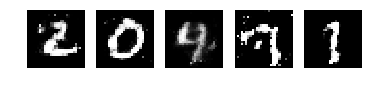

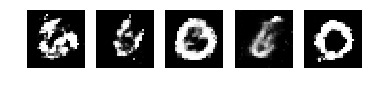

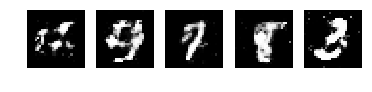

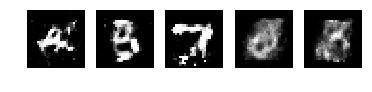

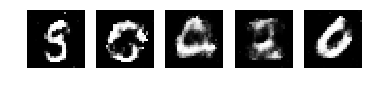

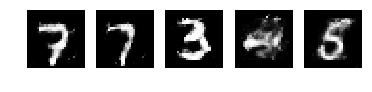

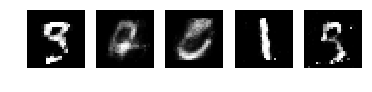

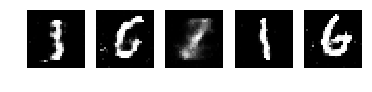

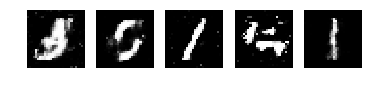

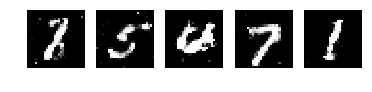

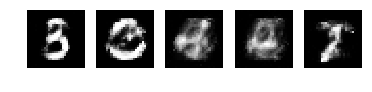

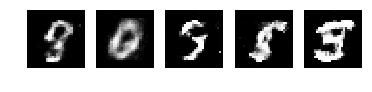

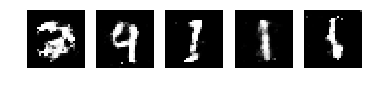

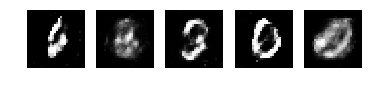

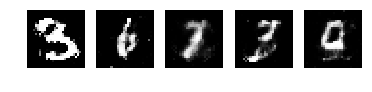

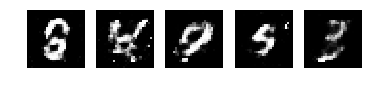

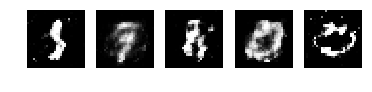

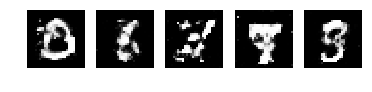

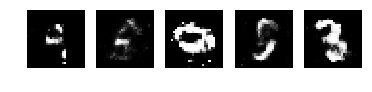

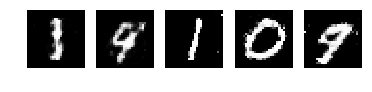

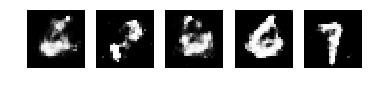

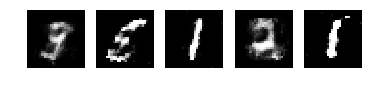

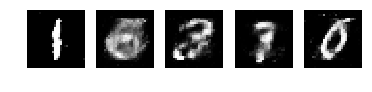

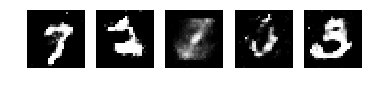

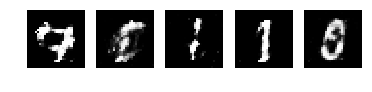

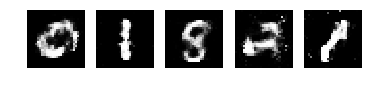

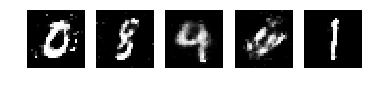

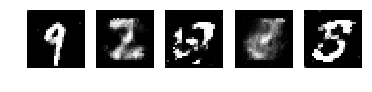

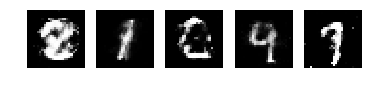

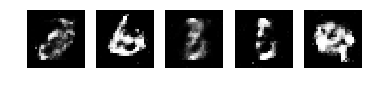

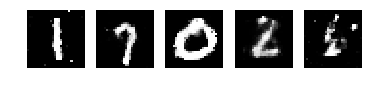

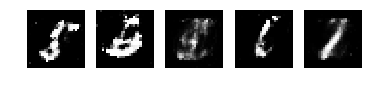

In [9]:
for i in range(hyperparams['epoch']):
    for j in range(hyperparams['sample_size']):
        plt.subplot(1, hyperparams['sample_size'], j + 1)
        plt.axis('off')
        plt.imshow(generate_sample_history[i, j].reshape(28, 28), cmap='gray')   
    plt.show()